# Image Classification - Welding Symbols

## 1. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, transforms
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Import custom modules
from resnet50_model import resnet50
from image_augmentation import generate_augmented_samples

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
# Define device for mac
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


## 2. Augment Data and Prepare Dataloaders

In [3]:
class AugmentedPILDataset(Dataset):
    """A custom dataset to wrap a list of (PIL image, label) samples."""
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image, label = self.samples[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

def create_augmented_dataloaders(data_dir, batch_size=32):
    """Generates an augmented dataset and splits it into train/val dataloaders."""
    # 1. Load the original dataset (as PIL images)
    original_dataset = datasets.ImageFolder(root=data_dir)
    class_names = original_dataset.classes

    # 2. Generate augmented samples in memory
    augmented_samples = generate_augmented_samples(original_dataset)

    # 3. Define transforms to be applied on-the-fly
    final_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # 4. Create a custom dataset from the augmented samples
    full_augmented_dataset = AugmentedPILDataset(augmented_samples, transform=final_transform)

    # 5. Split the augmented dataset into training and validation sets
    train_size = int(0.8 * len(full_augmented_dataset))
    val_size = len(full_augmented_dataset) - train_size
    train_dataset, val_dataset = random_split(full_augmented_dataset, [train_size, val_size])

    # 6. Create DataLoaders
    dataloaders = {
        'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0),
        'val': DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    }
    
    dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}

    return dataloaders, dataset_sizes, class_names

data_loaders, dataset_sizes, class_names = create_augmented_dataloaders('assets/welding-dataset_64x64_resized', batch_size=32)
print(f"Dataset sizes: {dataset_sizes}")
print(f"Class names: {class_names}")

Starting with 45 original samples.
Generating augmentations based on counts: {'scale_zoom': 400, 'brightness': 400, 'contrast': 400, 'noise': 400, 'multi': 800}
Finished generating. Total samples: 2445
Dataset sizes: {'train': 1956, 'val': 489}
Class names: ['arrow-side_back-or-backing', 'arrow-side_bevel', 'arrow-side_edge', 'arrow-side_fillet', 'arrow-side_flare-bevel', 'arrow-side_flare-v', 'arrow-side_j', 'arrow-side_plug-or-slot', 'arrow-side_scart-for-brazed-joint', 'arrow-side_seam', 'arrow-side_spot-or-projection', 'arrow-side_square', 'arrow-side_stud', 'arrow-side_surfacing', 'arrow-side_u', 'arrow-side_v', 'both-sides_bevel', 'both-sides_edge', 'both-sides_fillet', 'both-sides_flare-bevel', 'both-sides_flare-v', 'both-sides_j', 'both-sides_scart-for-brazed-joint', 'both-sides_square', 'both-sides_u', 'both-sides_v', 'empty', 'no-arrow-side-or-other-side-significance_seam', 'no-arrow-side-or-other-side-significance_spot-or-projection', 'no-arrow-side-or-other-side-significanc

## 3. Visualize a Batch of Training Data

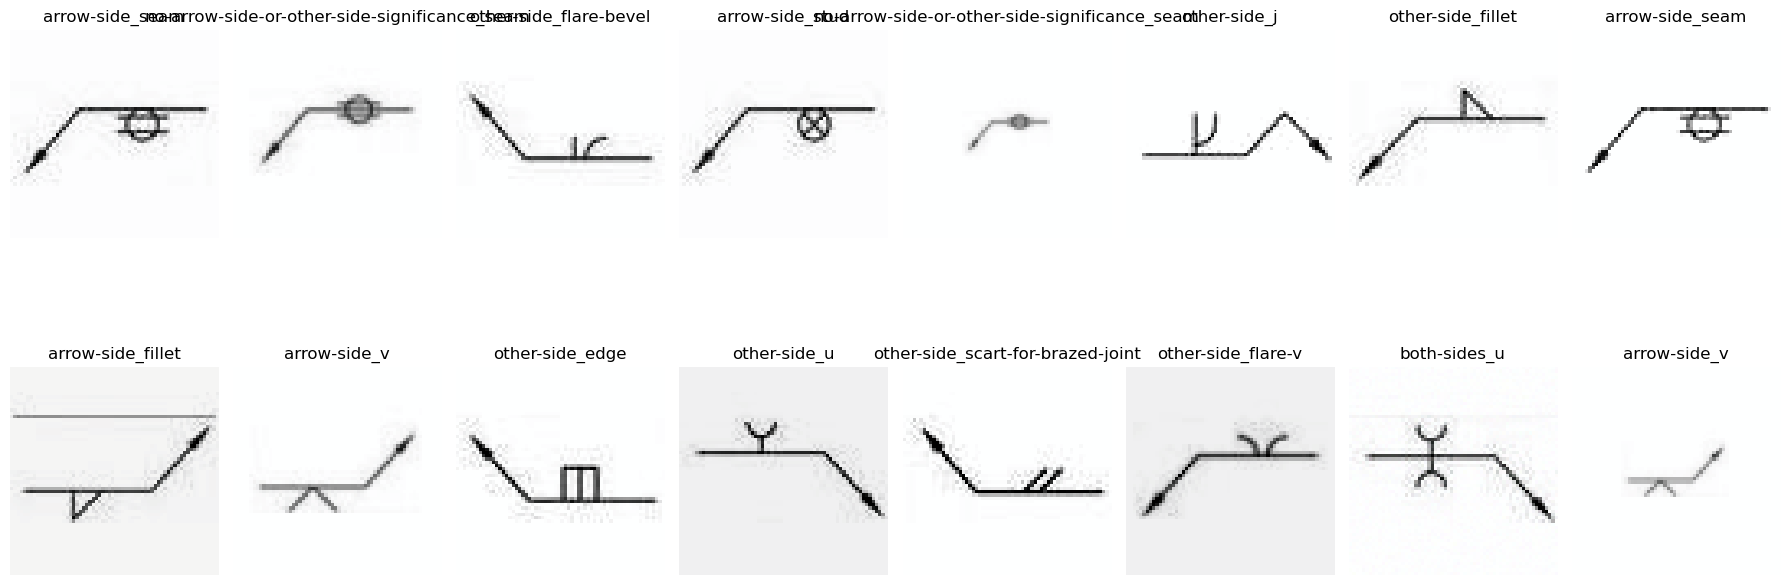

In [4]:
def visualize_batch(dataloaders, class_names, batch_size=16):
    """Visualizes a batch of augmented training images with class names."""
    # Get a batch of images and labels
    images, labels = next(iter(dataloaders['train']))
    n = min(images.size(0), batch_size)

    # Denormalize images for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(18, 8))
    for i in range(n):
        img = images[i].permute(1, 2, 0).cpu().numpy()
        img = img * std + mean
        img = np.clip(img, 0, 1)
        plt.subplot(2, (n + 1) // 2, i + 1)
        plt.imshow(img)
        # Convert label tensor to int if needed
        label_idx = labels[i].item() if hasattr(labels[i], "item") else int(labels[i])
        plt.title(class_names[label_idx])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_batch(data_loaders, class_names)

## 4. Initialize Model, Loss, and Optimizer

In [5]:
# Initialize the ResNet-50 model with the correct number of classes
model = resnet50(num_classes=len(class_names))
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("Model, loss function, and optimizer initialized.")
print(f"Model loaded on {next(model.parameters()).device}")

Model, loss function, and optimizer initialized.
Model loaded on mps:0


# Train the Model

Epoch 1/10
----------
train Loss: 3.1857 Acc: 0.2536
val Loss: 2.2033 Acc: 0.3292
Epoch 2/10
----------
train Loss: 1.4677 Acc: 0.6038
val Loss: 1.4333 Acc: 0.6237
Epoch 3/10
----------
train Loss: 0.8882 Acc: 0.7459
val Loss: 1.1712 Acc: 0.6973
Epoch 4/10
----------
train Loss: 0.5998 Acc: 0.8379
val Loss: 0.6853 Acc: 0.7996
Epoch 5/10
----------
train Loss: 0.5834 Acc: 0.8456
val Loss: 0.5694 Acc: 0.8466
Epoch 6/10
----------
train Loss: 0.5094 Acc: 0.8666
val Loss: 0.6198 Acc: 0.8384
Epoch 7/10
----------
train Loss: 0.6128 Acc: 0.8333
val Loss: 0.6170 Acc: 0.8139
Epoch 8/10
----------
train Loss: 0.2837 Acc: 0.9213
val Loss: 0.3673 Acc: 0.8916
Epoch 9/10
----------
train Loss: 0.3135 Acc: 0.9146
val Loss: 0.3800 Acc: 0.8814
Epoch 10/10
----------
train Loss: 0.1978 Acc: 0.9412
val Loss: 0.3454 Acc: 0.9080


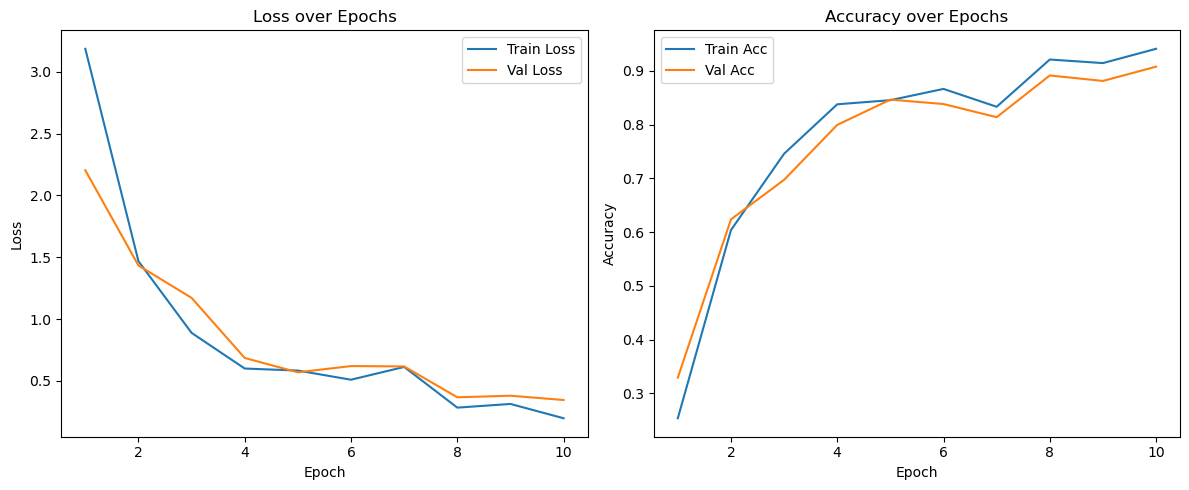

Model trained and saved successfully!


In [6]:
# Train the Model
def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=10):
    """Trains the model, prints training/validation loss, and plots loss/accuracy curves."""
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_accuracies.append(epoch_acc.item())

    # Plot loss and accuracy curves
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Acc')
    plt.plot(epochs, val_accuracies, label='Val Acc')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return model

# Train the model
trained_model = train_model(model, data_loaders, dataset_sizes, criterion, optimizer, num_epochs=10)
# Save the trained model
torch.save(trained_model.state_dict(), 'assets/models/trained_resnet50.pth')
print("Model trained and saved successfully!")